## Network Science Project 2
### Autumn 2022
### Due: December 15th, 1:00pm GMT

Please provide the following information:

CID: 02024600

In [1]:
# Do not modify this cell or import any other modules
# without explicit permission. 
# You should run this cell before running the code below.
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#You may also use scipy as needed

### Overview

In this assignment, you will be investigating a model for the spread of an infectious disease between communities via an air transportation network. You have been provided a file containing the network data which should be stored in the same folder as this notebook. Run the cell below to verify that you can load the graph.

In [2]:
import networkx as nx
g = nx.read_graphml('P2.graphml')
g = nx.convert_node_labels_to_integers(g)
print(g)

Graph with 2905 nodes and 15645 edges


The output from the cell above should be: "Graph with 2905 nodes and 15645 edges"

### 1. (6 points)

(a) Create a well-designed plot which displays (i) the degree distribution of the provided graph, (ii) the stationary expected degree distribution for the simple Barabasi-Albert model analyzed in lecture, and (iii) the degree distribution for the $G_{Np}$ model with $N$ chosen to match the number of nodes in the provided graph and $p$ chosen so that the expected degree matches the average degree of the provided graph. Note: it may be helpful to use *scipy.stats.binom*


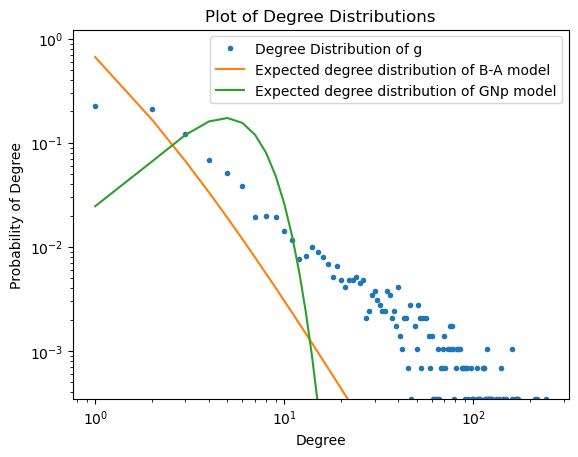

In [3]:
import scipy as sp # import scipy

degg = [g.degree[r] for r in g] # list of degrees of g

avgdegg = sum(degg) / (2 * 2905) # calculate mean degree of g

gdegree, gcountdegree = np.unique(degg, return_counts = True) # count the number of each degree in g

gprob = gcountdegree / 2905 # calculate naive probability of each degree

maxgdegree = max(gdegree) # find max degree of g
x  = range(1, maxgdegree) # create range for x from 1 to max degree of g

baprob = [4 / ((k + 2) * (k + 1) * k) for k in x] # using formula from lecture find expected probability distribution of
                                                  # Barabasi-Albert model

gnpprob = sp.stats.binom.pmf(x, 2905, avgdegg / 2904) # using formula from lecture find expected probability distribuiton
                                                        # of GNp model

# loglog plots of different degree distributions    
plt.loglog(gdegree, gprob, ls = '', marker = '.', label = 'Degree Distribution of g') # plot degree distribution of g
plt.loglog(x, baprob, label = 'Expected degree distribution of B-A model') # plot degree distribution of Barabasi-Albert model
plt.loglog(x, gnpprob, label = 'Expected degree distribution of GNp model') # plot degree distribution fo GNp model

plt.ylim([min(gprob), max(gprob) + 1]) # set y-axis ranges to show
plt.xlabel('Degree') # x axis label
plt.ylabel('Probability of Degree') # y axis label
plt.title('Plot of Degree Distributions') # title
plt.legend() # legend

(b) Based on your plot and your understanding of the relevant models, carefully discuss the suitability of the $G_{Np}$ model and the linear preferential attachment assumption for generating graphs like the provided air transportation network.

The $G_{Np}$ is not suitable for generating graphs like the provided air tranpsortation network as from the lectures we know most large complex netwroks exhibit different behaviour. Large complex networks typically have large degree hubs and $\overline{k}$ is not very important but these characteristics are not in the $G_{Np}$ model. Furthermore, we can see the unsuitability of the $G_{Np}$ model as the green line in the plot does not follow the blue dots closely. 

The preferential attachment model is a better assumption for modelling graphs like the one provided as it has a higher probability of forming large hubs. However, it is still not perfectly suitable as can be seen from the plot as the orange line is below the blue dots. A resolution to this could be to add more links per iteration as the degree distribution for this is $p_k \approx \frac{2q(q+1)}{(k+2)(k+1)k}$ so we could adjust q until it follows the graph given more closely.

### 2. (7 points) 
In this question, you will develop code to simulate the spread of an infectious disease through $N$ communities connected by the provided air transportation network. Each node corresponds to a community characterized by: $x_i(t)$, the ratio of the the number in community $i$ who are infected and the original population of the community; similarly, $s_i(t)$ is the fraction of people who are susceptible with respect to the original population in community $i$. People may also be recovered with immunity so initially, $x_i+s_i+r_i=1$.
The governing equations are,

\begin{gather*}
  \frac{ds_i}{dt} = -\beta s_i x_i + \alpha \sum_{j=0}^{N-1}\frac{A_{ij}}{k_i}(s_j-s_i) \\
  \frac{dx_i}{dt} = \beta s_i x_i -\mu x_i + \alpha \sum_{j=0}^{N-1}\frac{A_{ij}}{k_i}(x_j-x_i) \\
  i=0,1,2,...,N-1\\
\end{gather*}
Here, $A_{ij}$ is the adjacency matrix for the provided network, $k_i$ is the degree of node $i$, and $\alpha$, $\beta$, and $\mu$ are model parameters which must be specified.
The initial condition should correspond to only one specified node containing infectious people, $x_{i0}(t=0)=x0$, $s_{i0}=1-x0$, and all other nodes should have $s_j(t=0)=1$. Note that the graph nodes are numbered from $0$ to $N-1$ which is why the sums in the equations are over the same range.

You will now develop the function, *Cmodel*, so that it computes
    a numerical solution for this model on the network provided as input in the form of a NetworkX graph. The timespan of the simulation
    and other model parameters are also provided as input -- see the documentation for the function below.

(a) Complete the function, *RHS*, so that it efficiently computes and returns the
right-hand side of the model equations (see the function docstring below). You should assume that RHS will be called a very large
number of times within one call to *Cmodel* and construct your code accordingly.
You should also design your code for large complex simple graphs such as those found in table 2.1 in Barabasi, though it is recommended that you develop and test your code with much smaller graphs. Note that variables set "above" RHS will be available within RHS.
Add a brief discussion below explaining how you have designed your function and why it can be considered to be efficient.

(b) Add the needed code to *Cmodel* below to efficiently and accurately simulate the model for $Nt$ time steps from $t=0$ to $t=tf$
with the initial condition set as described above. The function should return an array containing $s_i$ and $x_i$ for each node at each time step (including the initial condition). Part (c) provides guidance on how accurate your code should be.

In [4]:
def Cmodel(g,i0=2,x0=0.0001,alpha=1e-2,beta=2,mu=1.0,tf=20,Nt=1000):
    """
    Simulate community network infectious disease model

    Input:
    g: N-node undirected Networkx graph with nodes numbered from 0 to N-1
    i0: node which is initially infected with x_i0=x0
    x0: magnitude of x(t=0) for node i0
    alpha,beta,mu: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: size Nt+1 array
    sarray: N x Nt+1 array containing s across the N network nodes at
            each time step
    xarray: N x Nt+1 array containing x across the N network nodes at
            each time step.

    """
    import numpy as np
    import networkx as nx

    N = g.number_of_nodes()
    tarray = np.linspace(0,tf,Nt+1)
    sarray = np.zeros((N,Nt+1))
    xarray = np.zeros((N,Nt+1))
    
    A = nx.adjacency_matrix(g).toarray() # define the adjacency matrix of g
 
    def RHS(t,y):
        """Compute RHS of model1 at time t
        input: y should be a size 2N array with y[:N] and y[N:2*N]
        corresponding to s on nodes 0 to N-1 and x on nodes 0 to
        N-1, respectively.
        output: dy, also a size 2N array corresponding to dy/dt
        """
        dy = np.zeros(2*N) #remove/modify as needed
        
        s = y[:N] # define vector s from y
        x = y[N : 2 * N] # define vector x from y
        
        ds = - beta * s * x + ((alpha * np.dot(A, s)) / np.sum(A, axis = 0)) - alpha * s # calculate ds
        dx = beta * s * x - mu * x + ((alpha * np.dot(A, x)) / np.sum(A, axis = 0)) - alpha * x # calculate dx
        
        dy = np.append(ds, dx) # join ds and dx

        return dy # return dy size 2N with dy[:N] and dy[N:2*N] corresponding to ds and dx respectively
    
    from scipy.integrate import solve_ivp # import differential equation solver
    
    # define initial values for s and x
    initials = np.ones(N) 
    initials[i0] = 1 - x0 
    initialx = np.zeros(N)
    initialx[i0] = x0
    
    initialy = np.append(initials, initialx) # join initial values for s and x
    
    # use differential equation calculator imported to solve system
    sol = solve_ivp(RHS, [min(tarray), max(tarray)], initialy, t_eval = tarray, method = 'LSODA', rtol = 1e-5)
    
    # define s and x values at times t
    sarray = sol.y[: N]
    xarray = sol.y[N : 2 * N]
    
    return tarray,sarray,xarray

We have created initial value vectors and then passed them through the solve_ivp function from the scipy integrate package. In solve_ivp we have used the LSODA method, as it is the most accurate, and set rtol to be $1 \times 10^{-5}$ so that it meets the accuracy requirement in (c).

(c) Design a test for your code for the case alpha=0, beta=0, mu=1, x0=1. As part of your test, for $t$ such that $0 \leq t \leq 10$, create a figure that clearly illustrates how accurate (or inaccurate) your code is for these parameter values. Your code in *Cmodel* should be designed so that the magnitude of the difference between the exact solution and the computed solution for $x_{i0}$ at $t=1$ is less than $10^{-5}$. Provide a brief discussion of your figure below.  

C:\Users\maxfr\AppData\Local\Temp\ipykernel_20076\1856460208.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(g).toarray() # define the adjacency matrix of g


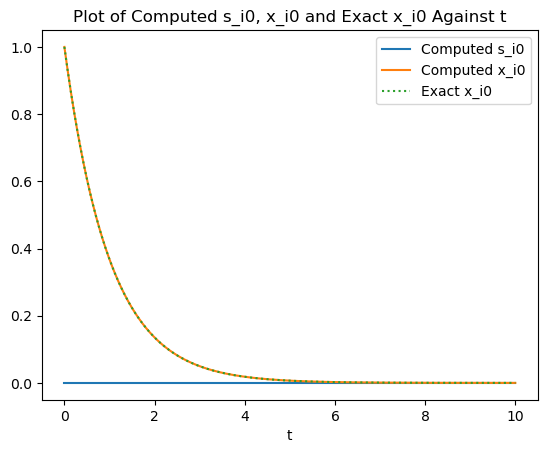

In [5]:
# Add code for 2.(c) here

t1, s1, x1 = Cmodel(g, i0 = 2, x0 = 1, alpha = 0, beta = 0, mu = 1, tf = 10) # test function from b

plt.plot(t1, s1[2], label = 'Computed s_i0') # plot computed solution for si0 
plt.plot(t1, x1[2], label = 'Computed x_i0') # plot computed solution for xi0
plt.plot(t1, np.exp(-t1), ls = ':', label = 'Exact x_i0') # plot exact solution for xi0

plt.xlabel('t') # x axis label
plt.title('Plot of Computed s_i0, x_i0 and Exact x_i0 Against t') # title
plt.legend() # legend

In [6]:
print(abs(x1[2][100] - np.exp(-1))) # value of difference between computed and exact value

4.792738020620302e-06


The figure above shows the computed $x_{i0}(t)$ and $s_{i0}(t)$ along with the exact $x_{i0}(t)$ against $t$. $x_{i0}(t)$ is $e^{-t}$ as 

$$\int \frac{dx_{i0}}{dt} \,dt = \int -t \,dt \Longrightarrow x_{i0}(t) = Ae^{-t}$$

where $A = 1$ as the intial condition $x_{i0}(t = 0) = 1$.

As you can see from the graph my Cmodel is accurate as $x_{i0}(t)$ follows $e^{-t}$ very closely and upon inspection at $t = 1$ the absolute difference is less than $10^{-5}$ as required in the question. $s_{i0}(t)$ remains zero as its intial condition is zero and $\frac{ds_{i0}}{dt} = 0$.

For the remaining nodes, $j \neq i0$, $x_j(t)$ and $s_j(t)$ stay constant equal to their initial values $0$ and $1$ respectively as $\frac{dx_{j}}{dt} = 0$ and $\frac{ds_{j}}{dt} = 0$.

### 3. (7 points)

For this question, set $i0=2$, $x0=10^{-4}$, $\alpha=10^{-2}$, $\beta=2$, and $\mu=0$. Carefully investigate and analyze the spread of disease on the provided network for $0\leq t\leq 4$. Your analysis should (1) carefully present simulation results to support your observations and conclusions, and (2) where appropriate, make clear connections to the model equations and their properties. You may include up to four well-designed figures to support your discussion and conclusions. You may vary the model parameters if it helps you answer the question, however the focus of your analysis should be on results generated with the specified parameters.

In [7]:
t2, s2, x2 = Cmodel(g, i0 = 2, x0 = 1e-4, alpha = 1e-2, beta = 2, mu = 0, tf = 4) # calculate s, x values with parameters 
                                                                                  # defined in question

C:\Users\maxfr\AppData\Local\Temp\ipykernel_20076\1856460208.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(g).toarray() # define the adjacency matrix of g


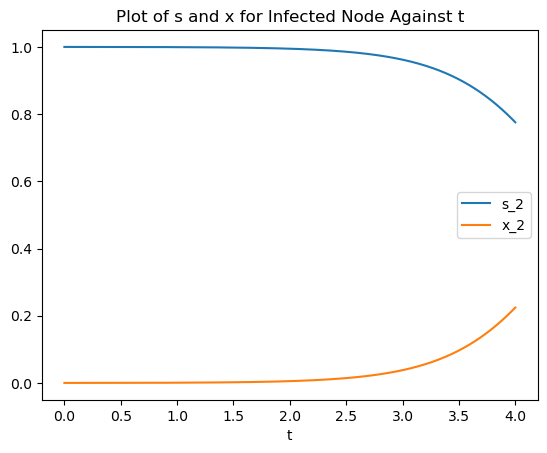

In [8]:
plt.plot(t2, s2[2], label = 's_2') # plot s for infected node
plt.plot(t2, x2[2], label = 'x_2') # plot x for infected node

plt.xlabel('t') # x axis label
plt.title('Plot of s and x for Infected Node Against t') # title
plt.legend() # legend

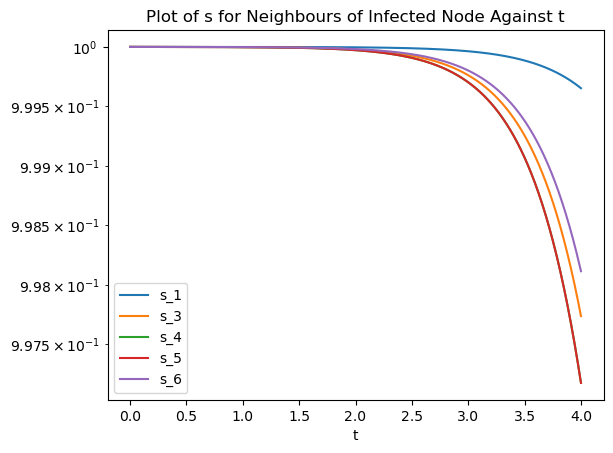

In [9]:
# plot s for neighbours of infected nodes
for r in g.neighbors(2):
    plt.plot(t2, s2[r], label = 's_{}'.format(r))

plt.xlabel('t') # x axis label
plt.title('Plot of s for Neighbours of Infected Node Against t') # title
plt.yscale('log') # log scale y axis
plt.legend() # legend

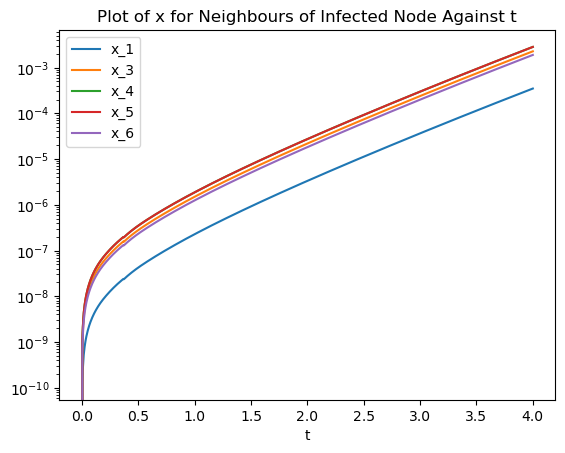

In [10]:
# plot x for neighbours of infected nodes
for r in g.neighbors(2):
    plt.plot(t2, x2[r], label = 'x_{}'.format(r))

plt.xlabel('t') # x axis label
plt.title('Plot of x for Neighbours of Infected Node Against t') # title
plt.yscale('log') # log scale y axis
plt.legend() # legend

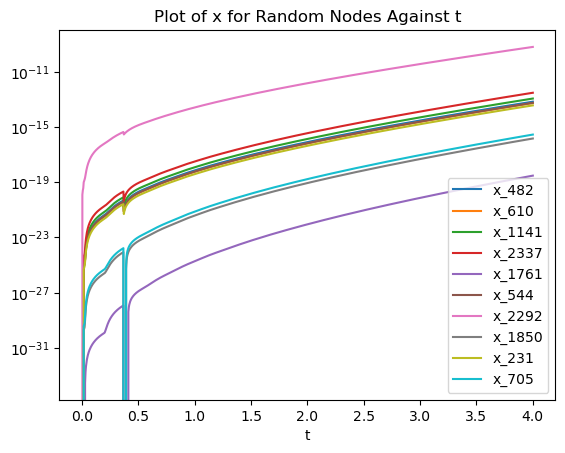

In [11]:
random = np.random.randint(0, 2905, 10) # list of random integers between 0 (inclusive) and 2905 (exclusive)

# plot x for random nodes
for r in random:
    plt.plot(t2, x2[r], label = 'x_{}'.format(r))

plt.xlabel('t') # x axis label
plt.title('Plot of x for Random Nodes Against t') # title
plt.yscale('log') # log scale y axis
plt.legend() # legend

From the first graph, we see that $x_2(t)$ and $s_2(t)$ are reflections of each other in the line $y = 0.5$ and that they both begin to converge towards each other with a visibile difference at $t = 2$.

From the second and third graph, I have plotted $x(t)$ and $s(t)$ of the neighbours of the infected node, and we can see a similar convergence in $x(t)$ and $s(t)$ but at a much slower rate than that of the infected node.

When looking at a random selection of nodes in the fourth graph we see they follow a similar pattern to the third graph. However we can see in this graph there is a small imperfection at around $t = 0.4$ where there is a sudden valley. 

For graphs two to four I have scaled the y-axis so it has a log scale in order to see greater detail in the graphs. 

### Further guidance

* You should submit both your completed Jupyter notebook and *either* a pdf version or html version of your notebook (generated using File --- Download as). If you cannot generate a pdf, try installing latex first, or submit an html version instead.
    To submit your assignment, go to the module Blackboard page and click on Project 2. There will be an option to attach your completed Jupyter notebook and pdf/html file to your submission. (these should be named *project2.ipynb* and *project2.pdf* or *project2.html*). 
* You may use numpy, scipy, networkx, and matplotlib as needed. Please do not any use any other packages without explicit permission.
* Marking will be based on the correctness of your work, the efficiency of your code for question 2(a) and (b), and the degree to which your submission reflects a good understanding of the material we have covered. While creative ideas based on class material are welcome, you are not expected to base your work on new ideas/concepts/methods that have not been covered (and it is unlikely that credit will be given for such work).
* This assignment requires sensible time-management on your part. Do not spend so much time on this assignment that it interferes substantially with your other modules. If you are concerned that your approach to the assignment may require an excessive amount of time, please get in touch with the instructor. 
* Questions about the assignment should be asked in private settings. This can be a "private" question on Ed (which is distinct from "anonymous") or asking for a one-on-one meeting during office hours.
* Please regularly backup your work. For example, you could keep an updated copy of your notebook on OneDrive.
* In order to assign partial credit, we need to understand what your code is doing, so please add comments to the code to help us.
* It may be helpful to initally develop your code in a Python module (outside of a function) and run it in a qtconsole (or similar Python terminal) so that you can readily access the values of the variables you are using.
* Feel free to use/modify codes that I have provided during the term.
